# Basics of BOSSA

BOSSA is an object-oriented code, with its main tools organized in four modules: `imf`, `zams`, `sfh` and `sampling`. The description below references sections, equations, figures and tables from the first BOSSA paper. Broadly, all classes either implement **distributions**, or are **sampling** from distributions. In this project, one goal is to recompute weights for pre-sampled binaries without sampling again, so you mostly need to worry about the distribution classes.

* `imf`: self-explanatory, implements sec 2.1. All classes in this module are **distribution** classes.
    * `PowerLawIMF`: a general class for power-law-series IMFs with an arbitrary number of breaks.
    * `Star`: stellar IMF (sIMF), the `invariant` argument sets it to be either the Kroupa (2001) (`True`) or Jerabkova et al. (2018) (`False`, eqs 9-12) IMF, the latter based on the fit over metallicity by Marks et al. (2012); eq (9) is a case of a three-part power law series, and eq (7) is effectively a one-part power law series,
    * `EmbeddedCluster`: the embedded cluster IMF (eIMF) from Jerabkova et al. (2018), itself ultimately based on the fit over SFR by Gunawardhana et al. (2011) (eqs 7, 8)
    * `IGIMF`: the galaxy-wide IMF (gwIMF) from Jerabkova et al. (2018), integrating over the IMFs from `Star` and `EmbeddedCluster` (eq 13).
    ----
* `zams`: implements the correlated initial orbital parameter distributions from Moe & Di Stefano (2017) (MD17), the uncorrelated distributions, and draws orbital parameters for a list of masses. `ZAMSSystemGenerator` class is a **sampling** class, all others are **distribution** classes.
    * `EccentricityDistribution`: either always draws e=0 (`canonical=True`) or samples from the MD17 distribution (`canonical=False`) (sec 2.2.2),
    * `MassRatioDistribution`:  either uniform (`canonical=True`) or the correlated distribution from MD17 (`canonical=False`) (sec 2.2.1),
    * `CompanionFrequencyDistributionHighQ`: this only implements the original fit from MD17 for the companion frequency as a function of primary mass and period in pairs of stars with q>0.3; this is not supposed to be accessed directly, but is instead used by the next class (sec 2.2.3);
    * `CompanionFrequencyDistribution`: implements a log-uniform distribution (`uncorrelated=True`) or the distribution from MD17 for q>0.1 binaries (`uncorrelated=False`); the second case is calculated from `CompanionFrequencyDistributionHighQ` and an instance of `MassRatioDistribution` passed through the `q_distr` argument, as in eq (15) (sec 2.2.3),
    * `MultipleFraction`: computes multiplicity fractions (single fraction, binary fraction, triple fraction...) as a function of primary mass, assuming either Only Binaries (`only_binaries=True`, fig 7) or All Multiples (`only_binaries=False`, fig 6); multiplicity fractions are computed following eqs (16-18); if `only_binaries=True`, they are summed into a single binary fraction as in eq (19) (section 2.2.4);
    * `ZAMSSystemGenerator`: this class takes a list of masses (sampled from some IMF or however you like), and uses it to generate ZAMS systems of arbitrary order. Once the class is setup, everytime the user calls `ZAMSSystemGenerator().sample_system(ncomp, ncomp_max)`, it generates and returns a system, and remove its primary and companion masses from the original list of masses. This is the "sampling without repetition" method motivated by star formation physics discussed in secs 3.2.1 and 3.2.2. From the sampling steps defined in sec 3.2.2, this class implements step iii for all companions simultaneously. It is called by `sampling.SimpleBinaryPopulation`, which implements the other steps.
    ----
* `sfh`: implements all of the "environmental condition" distributions (from Chruślińska et al. 2019, 2020) that define the metallicity-specific cosmic star formation history (cSFH; this is the star formation rate density, Msun/yr/Mpc-3, as a function of metallicity and SFR), from section 2.3. These are the Star Formation-Mass Relation (SFMR, SFR as a function of galaxy stellar mass and redshift); the Mass-(Gas) Metallicity Relation (MZR, gas metallicity as a function of galaxy stellar star mass and redshift); and the Galaxy Stellar Mass Function (density of galaxies over galaxy stellar mass and redshift). All classes in this module are **distribution** classes. They are not used for computing weights, *but* can be used when computing merger rates later. They are not discussed in detail in the BOSSA paper, but in the original papers.
    * `BoogardSFMR`, `SpeagleSFMR`, `TomczakSFMR`: different models for the SFMR, which the next class combines for the options actually available in BOSSA;
    * `SFMR`: combines the three classes above to provide the Sharp, Moderate and No Flatenning SFMRs defined in section 2.3;
    * `MZR`: provides all four options for the MZR described in section 2.3;
    * `GSMF`: provides the Fixed Slope and Varying Slope models for the GSMF described in section 2.3;
    * `Corrections`:  implements the correcting factors for the SFMR when using the Jerabkova et al. (2018) IMF (Varying). The factors are multiplicative factors computed as a function of the uncorrected SFR and metallicity. They were originally computed for a dense discrete grid by Chruślińska et al. (2020), which is freely available, and is included in BOSSA with permission from Martyna Chruślińska. This class interpolates from that grid for abritrary SFR, metallicity.
    * `ChruslinskaSFRD`: computes the SFR density (SFRD) over metallicity and SFR for any combination of the SFMR, MZR and GSMF options. This generates the background colorplot from figures 8 and 9 in the BOSSA paper, inspired by figure 7 of Chruślińska et al. (2020).
----
* `sampling`: as the name implies, all the classes in this module are **sampling** classes. Because for computing weight you will not be resampling binaries, you don't need to worry about these too much for now.
    * `RandomSampling`: this class takes a distribution, creates an interpolator over it, and then samples from the interpolator. It's meant to be used with distributions that are computed numerically (the Jerabkova IMF), to avoid having to do a numerical integral for every single probability.
    * `GalaxyStellarMassSampling`: this samples galaxy stellar masses from an instance of `sfh.GSMF` for a fixed redshift through the quantile method. The *n-quantiles* of a distribution over some $x$ are the $n$ $x$ bins that each contain $1/n$ of the total sample/population/probability. This is the method used in "scatterless sampling", as described in section 3.1 and illustrated in the bottom-left panel of figure 8.
    * `GalaxyGrid`: generates a sample of "galaxies", i.e., (z,SFR,Z) sets, the red crosses in figures 8 and 9. Samples from the GSMF, MZR and SFMR either with or without scatter as described in section 3.1.
    * `SimpleBinaryPopulation`: generates a population (actually including systems up to any arbitrary order) for fixed z,SFR,Z (called a single stellar population, or SSP, in the paper). This class combines methods from all of the other classes to define its distributions. It generates the mass pool from the IMF and implements steps (i-iv) from section 3.2.2, calling `zams.ZAMSSystemGenerator` to execute step iii.
    * `CompositeBinaryPopulation`: generates the complete population corresponding to all galaxies in a grid from `GalaxyGrid`, called a composite stelar population in the paper (CSP). It simply takes in a grid generated with `GalaxyGrid` and calls `SimpleBinaryPopulation`on each galaxy.



BOSSA also has two auxiliary classes: `constants`, which holds physical constants, file paths and other immutable data shared by all modules; and `utils`, which holds various utility functions called by different modules (including the metallicity conversion). Many of the functions in the latter are deprecated.

Lastly, BOSSA also contains the `postprocessing` class. This is the class that allows it to interact with COMPAS and which the computation of weights will provide a much more efficient alternative to. It contains functions for reformatting COMPAS output, cross-matching a BOSSA-generated initial population with COMPAS for re-sampling and an alternative (and more expensive) method for calculating merger rates from BOSSA+COMPAS output. Hopefully you will not need to touch this, as it is currently completely undocumented.

*Note: if you happen to take some time to look through the code and experiment beyond what is described here, remember that methods that start with an underscore are 'private'[1] and not meant to be accessed directly. Calling them might cause unexpected behavior, but if you are curious, don't let that stop you!* 

*[1]Note of the note: Python doesn't have real private methods like some other languages; tagging methods with a _ is merely a convention to warn users that the method is not meant to be accessed directly*

# Using the distributions

While all the distributions have complete documentation, and the documentation for some contains examples, let us still go through the basics of calling them. BOSSA isn't yet properly packaged and available through pip, so you will have to clone the repository into your machine. You can use the environment.yml to prepare an environment for BOSSA to run in with an environment manager like conda. No further installation is required for the distribution classes.

Let's start by importing everything we need, including utilities and the distributions that you will need to compute binary weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append('../src')
from bossa.imf import Star, EmbeddedCluster, IGIMF
from bossa.zams import EccentricityDistribution, MassRatioDistribution, CompanionFrequencyDistribution, MultipleFraction

You can take advantage of the documentation by calling the help function (but all the information is also in https://lmdesa.github.io/BOSSA/). Let's start with an example.

For any class, you can get the complete class docstring by calling `help`. This will also tell you what arguments the class expects to be initialized with, what they mean and whether they have default values. The `Star` class, for example, by default creates a varying, Jerabkova IMF, at solar metallicity, with a total embedded cluster mass of $10^8\,\mathrm{M}_\odot$ and a minimum possible cluster mass of $5\,\mathrm{M}_\odot$.

In [2]:
help(Star)

Help on class Star in module bossa.imf:

class Star(PowerLawIMF)
 |  Star(m_ecl=10000000.0, m_ecl_min=5.0, feh=0.0, invariant=False)
 |
 |  Compute the stellar initial mass function.
 |
 |  Compute the stellar initial mass function (sIMF) specific to a given
 |  star-forming region (embedded cluster, or ECL), with a set [Fe/H],
 |  and a total ECL stellar mass, ``m_tot``. According to the
 |  ``invariant`` attribute, the sIMF might either follow an invariant
 |  Kroupa (2001) [2]_ IMF or a metallicity- and star formation rate-
 |  dependent Jerabkova et al. (2018) [3]_ IMF.
 |
 |  Attributes
 |  ----------
 |  x
 |  g1
 |  g2
 |  feh : float
 |      Embedded cluster metallicity in [Fe/H].
 |  m_ecl_min : float
 |      Absolute minimum embedded cluster mass.
 |  _m_max : float
 |      Maximum stellar mass. Embedded cluster-specific.
 |  k1 : float
 |      m<0.5 IMF normalization constant.
 |  k2 : float
 |      0.5<=m<1 IMF normalization constant.
 |  k3 : float
 |      1<= IMF normaliz

Calling help on the class should give the docstring for all methods. If you want to get the docstring for a method directly, you can also call

In [3]:
help(Star.get_mmax_k)

Help on function get_mmax_k in module bossa.imf:

get_mmax_k(self)
    Use Scipy's fsolve to solve the two constraints with adequate
    initial guesses for k3 and _m_max.

    After solving for k3 and _m_max, k1 and k2 are immediately
    determined. Automatically sets the IMF to zero for all
    masses if the star-forming region mass is below a minimum of 5
    solar masses.



We can now look into the basic way to use each class.

## IMFs

The IMF classes will all allow you to get the dN/dM, which you can treat as a probability density, from an `imf` method. Often there are "setup" methods that need to be called before you can compute probabilities (this is also true for the other ZAMS functions). Generally, the docstring should let you know if setup is required, and not doing the setup should give an error message that tells you what to do (but let me know if instructions are missing).

For example, if we try to use the stellar IMF with default settings without setting up, we get an informative error message.

In [4]:
star = Star()
star.imf(100)

/home/lucasmdesa/Documents/GitHub/BOSSA/tutorials/../src/bossa/imf.py:327: UserWarning: m_max not yet defined. Please run set_mmax_k().
  warnings.warn('m_max not yet defined. '


Let's do it properly now.

In [5]:
star = Star()
star.get_mmax_k()

What did we just do? We can ask Python for help.

In [6]:
help(star.get_mmax_k)

Help on method get_mmax_k in module bossa.imf:

get_mmax_k() method of bossa.imf.Star instance
    Use Scipy's fsolve to solve the two constraints with adequate
    initial guesses for k3 and _m_max.

    After solving for k3 and _m_max, k1 and k2 are immediately
    determined. Automatically sets the IMF to zero for all
    masses if the star-forming region mass is below a minimum of 5
    solar masses.



We see that this numerically solves the two integrals that define k3 and m_max in IGIMF theory, equations 4 and 5 in the first BOSSA paper. This is done to set the two parametes regardless of whether the IMF is invariant or not. Once the setup is done, we can get the IMF.

<>:28: SyntaxWarning: invalid escape sequence '\,'
<>:28: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_373575/845901994.py:28: SyntaxWarning: invalid escape sequence '\,'
  ax.set_ylabel('$\\mathrm{d}N/\\mathrm{d}M\,(\mathrm{M}_\odot^{-1})$')


Text(0, 0.5, '$\\mathrm{d}N/\\mathrm{d}M\\,(\\mathrm{M}_\\odot^{-1})$')

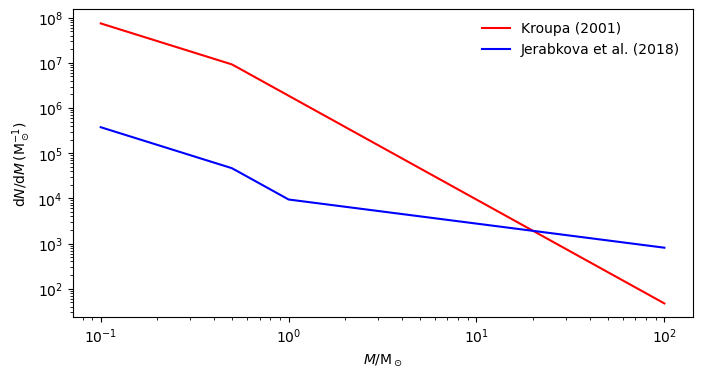

In [7]:
plot_m = np.logspace(-1, 2, 100)

# We can do
star = Star()
star.get_mmax_k()
plot_imf = np.array([star.imf(m) for m in plot_m])
# Note that, for technical reasons, many functions in bossa are not yet
# vectorized, so list comprehesion as above is required. However, you are always
# free to vecotrize them externally, like this:
star = Star(invariant=True)
star.get_mmax_k()
vec_imf = np.vectorize(star.imf)
plot_kroupa_imf = vec_imf(plot_m)

star = Star(invariant=False)
star.get_mmax_k()
vec_imf = np.vectorize(star.imf)
plot_jerabkova_imf = vec_imf(plot_m)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(plot_m, plot_kroupa_imf, 'r-', label='Kroupa (2001)')
ax.plot(plot_m, plot_jerabkova_imf, 'b-', label='Jerabkova et al. (2018)')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\mathrm{d}N/\\mathrm{d}M\,(\mathrm{M}_\odot^{-1})$')

Note how much flatter the Jerabkova IMF is: all else kept equal, it will produce considerably more black hole progenitors than the Kroupa IMF. But that is a Varying IMF, and this is for only one group of settings. Can you look use the docstring, help functions and the paper to find the physical variables that control the IMF and explore variations?

Remember that, in IGIMF theory, this is still the stellar IMF of a single embedded cluster (eIMF). To get the mass distribution of ECLs, we call a different class.

In [8]:
ecl = EmbeddedCluster()
ecl.imf(1e5)

Oops again!

In [9]:
ecl = EmbeddedCluster()
ecl.get_mmax_k()
ecl.imf(1e6)

7.464961182312918e-07

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_373575/3714957556.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$M_\mathrm{ecl}/\\mathrm{M}_\\odot$')
/tmp/ipykernel_373575/3714957556.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\\mathrm{d}N/\\mathrm{d}M_\mathrm{ecl}\,(\mathrm{M}_\odot^{-1})$')


Text(0, 0.5, '$\\mathrm{d}N/\\mathrm{d}M_\\mathrm{ecl}\\,(\\mathrm{M}_\\odot^{-1})$')

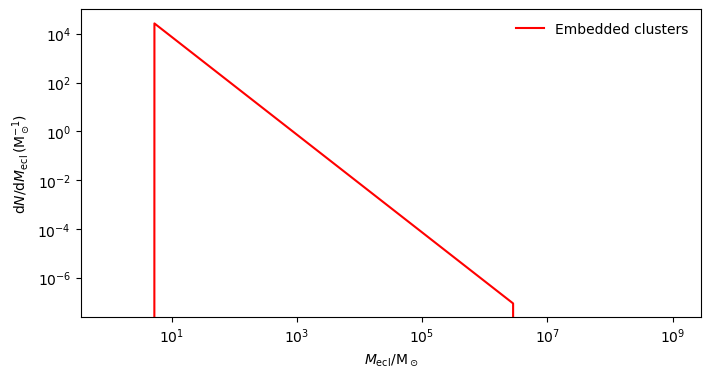

In [10]:
plot_m = np.logspace(0, 9, 100)

ecl = EmbeddedCluster()
ecl.get_mmax_k()
ecl.imf(1e5)
vec_imf = np.vectorize(ecl.imf)
plot_ecl_imf = vec_imf(plot_m)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(plot_m, plot_ecl_imf, 'r-', label='Embedded clusters')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$M_\mathrm{ecl}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\mathrm{d}N/\\mathrm{d}M_\mathrm{ecl}\,(\mathrm{M}_\odot^{-1})$')

Can you investigate variations in the cluster IMF too?

Although the IGIMF class is a lot more complicated under the hood, using it is still simple, if slower.

In [11]:
igimf = IGIMF()
igimf.set_clusters()
igimf.imf(100)

391.70104087223757

As before, anytime you meet a new method, if you want to get an idea about what it does without diving fully into the source code, you can call the help function.

In [12]:
help(igimf.set_clusters)

Help on method set_clusters in module bossa.imf:

set_clusters() method of bossa.imf.IGIMF instance
    Instantiate an EmbeddedCluster object and compute the maximum
    ECL mass.

    Instantiate an EmbeddedCluster object and compute the maximum
    ECL mass, which is also saved as an instance attribute.

    Warnings
    --------
    Must be called before the imf method, otherwise the eIMF will
    not be available for integration.



In [13]:
help(igimf.imf)

Help on method imf in module bossa.imf:

imf(m) method of bossa.imf.IGIMF instance
    Integrate the product of the sIMF and the eIMF with respect
    to ECL mass, for a given stellar mass.

    Integrate the product of the sIMF and the eIMF with respect to
    ECL mass, for a given stellar mass, using Scipy's quad function.

    Parameters
    ----------
    m : float
        Star mass at which to compute the imf.

    Returns
    -------
    imf : float
        IMF value at mass m.

    Warns
    ------
    UserWarning
        If 'clusters' is not defined (get_clusters() has not been
        run).



The Kroupa IMF is invariant, an so integrating it over all clusters in a galaxy would yield the Kroupa IMF again. With what we learned, we can now check how different the Jerabkova IMF looks to the Kroupa IMF in different environments.

Text(0, 0.5, '$\\mathrm{d}N/\\mathrm{d}M\\,(\\mathrm{M}_\\odot^{-1})$')

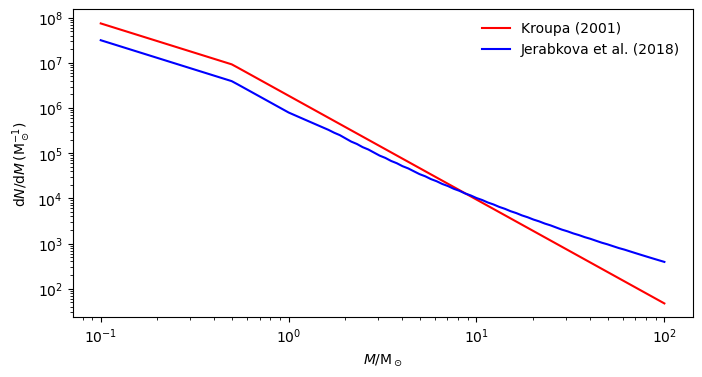

In [14]:
plot_m = np.logspace(-1, 2, 100)
sfr = 1 # Msun/yr
feh = 0  # remember that [Fe/H] ~ log10(Z/Zsun), so this is solar metallicity

star = Star(invariant=True)
star.get_mmax_k()
vec_imf = np.vectorize(star.imf)
plot_kroupa_imf = vec_imf(plot_m)

igimf = IGIMF(sfr=sfr, feh=feh)
igimf.set_clusters()
vec_imf = np.vectorize(igimf.imf)
plot_jerabkova_imf = vec_imf(plot_m)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(plot_m, plot_kroupa_imf, 'r-', label='Kroupa (2001)')
ax.plot(plot_m, plot_jerabkova_imf, 'b-', label='Jerabkova et al. (2018)')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\mathrm{d}N/\\mathrm{d}M\\,(\\mathrm{M}_\\odot^{-1})$')

Can you explore variations of the IMF with metallicity and the SFR? How would the weight (probability) of some your binaries change if you change the IMF?